In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
currentDir = os.path.dirname(os.path.abspath(__name__))
relativePath = 'ethData/ETHUSDT_1d.csv'
file_path= os.path.join(currentDir, relativePath)
df = pd.read_csv(file_path)
lenDataPoints = len(df)
from untrade.client import Client

In [2]:
def sma(m,n):
    s = 0
    for i in range(1, n+1):
        s += df['close'][m - i]
    s /= n
    return s

def ema(n):
    emaList = [0] * (n - 1)
    sma_ = sum(df['close'][:n]) / n
    emaList.append(sma_)
    k = 2/(n+1)
    for i in range(n, lenDataPoints):
        emaList.append(df['close'][i]*k + emaList[-1]*(1 - k))
    return emaList

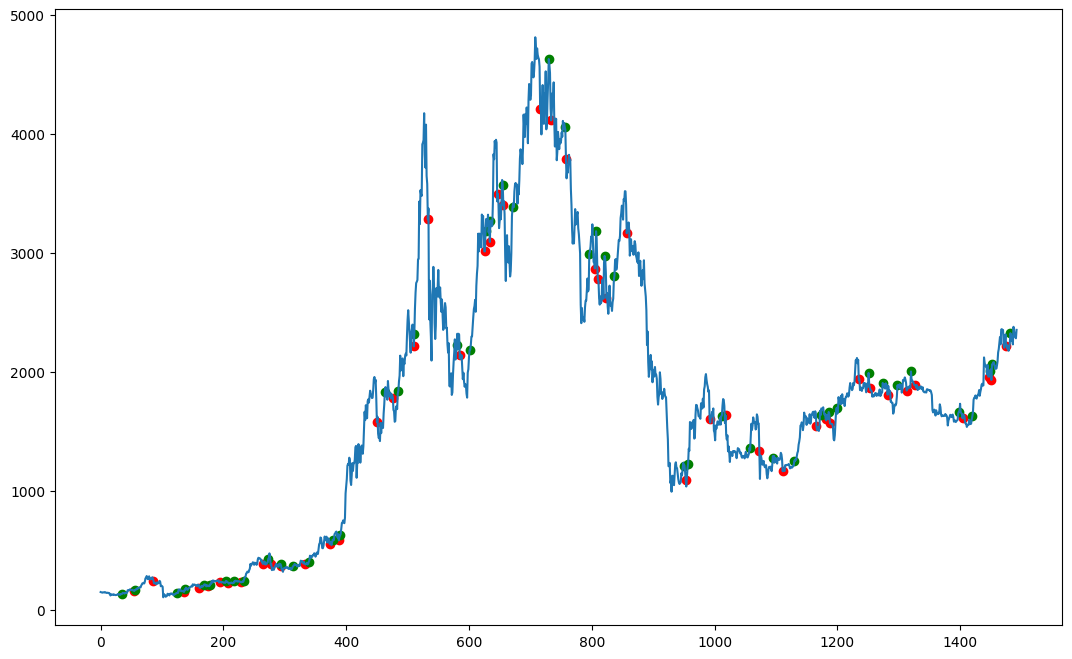

In [3]:
blue = ema(13)
red = ema(8)
green = ema(5)

check1 = 0
check2 = 0

signal = [0] * 13
for i in range(13, lenDataPoints):
    if blue[i] < red[i] < green[i]:
        if check1 == 0:
            signal.append(1)
            check1 = 1
        else:
            signal.append(0)
    else:
        if check1 == 1:
            signal.append(-1)
            check1 = 0
        else:
            signal.append(0)

df['signals'] = signal

plt.figure(figsize=(13,8))
l = list(range(lenDataPoints))
red_days = [i for i in range(lenDataPoints) if signal[i] == -1]          #long square-off
red_values = [df['close'][i] for i in range(lenDataPoints) if signal[i] == -1]      #long square-off
green_days = [i for i in range(lenDataPoints) if signal[i] == 1]         #long start
green_values = [df['close'][i] for i in range(lenDataPoints) if signal[i] == 1]     #long start
plt.plot(red_days, red_values, 'ro')
plt.plot(green_days, green_values, 'go')
plt.plot(df['close'])
plt.show()

In [4]:
df.head(lenDataPoints)

,Unnamed: 0,datetime,open,high,low,close,volume,signals
0,0,2019-12-01,151.38,152.50,145.50,150.65,394494.119,0
1,1,2019-12-02,150.72,151.30,146.67,148.59,395630.910,0
2,2,2019-12-03,148.59,149.80,145.62,147.10,495996.573,0
3,3,2019-12-04,147.12,152.22,142.96,145.35,684404.817,0
4,4,2019-12-05,145.36,148.88,143.77,148.04,441113.912,0
...,...,...,...,...,...,...,...,...
1488,1488,2023-12-28,2380.32,2455.52,2336.02,2345.96,4260463.058,0
1489,1489,2023-12-29,2345.98,2388.74,2254.72,2300.60,3866751.979,0
1490,1490,2023-12-30,2300.61,2325.00,2269.15,2293.26,1809956.531,0
1491,1491,2023-12-31,2293.26,2324.78,2258.00,2283.85,1671717.997,0


In [5]:
def perform_backtest(csv_file_path):
    client = Client()
    result = client.backtest(
        jupyter_id="akshatrai",
        file_path=csv_file_path,
        leverage=1,
    )
    return result

In [6]:
df = df.rename(columns={'Unnamed: 0': 'days'})
df.to_csv('signals.csv')
for i in range(len(df)):
    if df.loc[i, 'signals'] == 2 :
        df.loc[i, 'signals'] = -1
    elif df.loc[i, 'signals'] == -2 :
        df.loc[i, 'signals'] = 1
data = df[df['signals'] != 0]
res = data
res.to_csv("processed_data.csv", index=False)

csv_file_path = "processed_data.csv"
backtest_result = perform_backtest(csv_file_path)
last_value = None
for value in backtest_result:
    print(value)
    last_value = value

data: {
  "jupyter_id": "akshatrai",
  "result_type": "Main",
  "message": "Backtest completed",
  "result": {
    "static_statistics": {
      "From": "2020-01-04 00:00:00",
      "Total Trades": 47,
      "Leverage Applied": 1.0,
      "Winning Trades": 20,
      "Losing Trades": 27,
      "No. of Long Trades": 47,
      "No. of Short Trades": 0,
      "Benchmark Return(%)": 1634.404354,
      "Benchmark Return(on $1000)": 16344.043537,
      "Win Rate": 42.553191,
      "Winning Streak": 4,
      "Losing Streak": 5,
      "Gross Profit": 4448.325358,
      "Net Profit": 4377.825358,
      "Average Profit": 93.14522,
      "Maximum Drawdown(%)": 8.863356,
      "Average Drawdown(%)": 2.084023,
      "Largest Win": 1517.314375,
      "Average Win": 292.146812,
      "Largest Loss": -128.794086,
      "Average Loss": -54.263366,
      "Maximum Holding Time": "60 days 0:0:0",
      "Average Holding Time": "15 days 10:43:24",
      "Maximum Adverse Excursion": 26.845672,
      "Average A

In [1]:
import talib